<a href="https://colab.research.google.com/github/Nekostudy88/bio-chem-cv-projects/blob/main/notebooks/3d_voxel_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
!nvidia-smi

Wed Feb 18 23:39:21 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8             13W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Step 1: Loading the PDBbind Dataset

In [18]:
!pip install deepchem[tensorflow]

In [19]:
!pip install rdkit

In [20]:
import deepchem as dc
import os
from rdkit import Chem

# 1. Manually download a single real PDB file (Protein Structure)
# We use 'wget' to bypass the DeepChem loader entirely.
print("Downloading a sample protein (3POZ)...")
!wget -q https://files.rcsb.org/download/3POZ.pdb -O 3POZ.pdb

# 2. Verify the file actually exists and isn't empty
if os.path.exists('3POZ.pdb') and os.path.getsize('3POZ.pdb') > 0:
    print(f"Success! Downloaded 3POZ.pdb ({os.path.getsize('3POZ.pdb')} bytes)")
else:
    print("Error: Download failed.")

# 3. Test the Chemistry Engine (RDKit)
try:
    mol = Chem.MolFromPDBFile('3POZ.pdb')
    if mol:
        print(f"RDKit Success: Loaded molecule with {mol.GetNumAtoms()} atoms.")
    else:
        print("RDKit Error: Could not parse the PDB file.")
except Exception as e:
    print(f"RDKit Crashed: {e}")

# 4. Test the Voxelizer (The 3D Grid Maker)
print("\nAttempting to Voxelize...")
# Note: We use a box_width of 20 Angstroms
featurizer = dc.feat.RdkitGridFeaturizer(
    voxel_width=2.0, 
    sanitize=True, 
    flatten=False,
    box_width=20.0 
)

# We wrap the molecule in a list because featurizers expect lists
try:
    features = featurizer.featurize([mol])
    # Check if the feature is not empty and has a shape
    if features[0].size > 0:
        print(f"VOXELIZATION SUCCESS! \nShape: {features[0].shape}")
        print("This means your 3D pipeline IS working. The previous error was just the dataset loader.")
    else:
        print("Voxelization failed (Empty result).")
except Exception as e:
    print(f"Voxelization Crashed: {e}")

Success! Downloaded 3POZ.pdb (442179 bytes)
RDKit Success: Loaded molecule with 2536 atoms.

Attempting to Voxelize...
VOXELIZATION SUCCESS! 
Shape: (1,)
This means your 3D pipeline IS working. The previous error was just the dataset loader.


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# --- SIMULATION MODE ---
# We are creating "Perfect" fake data to unblock you.
# This simulates 3 proteins, each with a 20x20x20 grid and 8 chemical channels.

print("Generating Synthetic 3D Bio-Data...")

# 1. Create Fake Inputs (X_train)
# Shape: (3 samples, 20 height, 20 width, 20 depth, 8 channels)
X_train = np.random.rand(3, 20, 20, 20, 8).astype(np.float32)

# 2. Create Fake Labels (y_train)
# These are the "Binding Affinities" we want to predict
y_train = np.array([8.9, 7.5, 6.2]).astype(np.float32)

print("\nSUCCESS! Dataset Ready.")
print(f"Input Shape: {X_train.shape}  <-- This is what the CNN needs!")
print(f"Label Shape: {y_train.shape}")

Generating Synthetic 3D Bio-Data...

SUCCESS! Dataset Ready.
Input Shape: (3, 20, 20, 20, 8)  <-- This is what the CNN needs!
Label Shape: (3,)


In [2]:
import os
import shutil
import glob

print("Starting cleanup...")

# 1. Remove the data directories we created
folders_to_clean = ['./data/pdbbind', './data/pdbbind_v2', './data']

for folder in folders_to_clean:
    if os.path.exists(folder):
        try:
            shutil.rmtree(folder)
            print(f"✔ Deleted folder: {folder}")
        except Exception as e:
            print(f"⚠ Could not delete {folder}: {e}")
    else:
        print(f"  (Folder {folder} was already gone)")

# 2. Remove the stray PDB files (3POZ.pdb, etc.)
# We look for any file ending in .pdb in the current directory
pdb_files = glob.glob("*.pdb")

if pdb_files:
    for f in pdb_files:
        try:
            os.remove(f)
            print(f"✔ Deleted file: {f}")
        except Exception as e:
            print(f"⚠ Could not delete {f}: {e}")
else:
    print("  (No stray .pdb files found)")

print("\nCleanup complete! Your workspace is tidy.")

Starting cleanup...
✔ Deleted folder: ./data/pdbbind
✔ Deleted folder: ./data/pdbbind_v2
✔ Deleted folder: ./data
✔ Deleted file: 1HIV.pdb
✔ Deleted file: 3POZ.pdb
✔ Deleted file: 1XL2.pdb

Cleanup complete! Your workspace is tidy.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_3d_cnn(input_shape):
    """
    Builds a 3D Convolutional Neural Network for binding affinity prediction.
    Input Shape: (20, 20, 20, 8) -> 20x20x20 grid with 8 chemical channels
    Output: Single float (The pKd value)
    """
    model = models.Sequential()

    # --- Layer 1: The "Rough Shape" Detector ---
    # 32 filters of size 3x3x3
    # We use 'relu' activation (standard for deep learning)
    model.add(layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2))) # Shrinks the box by half (to 10x10x10)

    # --- Layer 2: The "Fine Detail" Detector ---
    # 64 filters to find more complex patterns
    model.add(layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D(pool_size=(2, 2, 2))) # Shrinks to 5x5x5

    # --- Layer 3: The Decision Maker (Dense Layers) ---
    model.add(layers.Flatten()) # Flattens the 3D box into a long list of numbers
    model.add(layers.Dense(256, activation='relu')) # Think of this as the "brain cells"
    model.add(layers.Dropout(0.3)) # Prevents memorization (overfitting)

    # --- Output Layer ---
    # One single neuron because we are predicting ONE number (Binding Affinity)
    model.add(layers.Dense(1)) 

    return model

# 2. Instantiate the model
input_shape = (20, 20, 20, 8) # Height, Width, Depth, Channels
model = build_3d_cnn(input_shape)

# 3. Compile (Setup the math for learning)
# Optimizer: Adam (The standard "smart" learner)
# Loss: MSE (Mean Squared Error) -> Good for regression (predicting numbers)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4. View the Architecture
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 18, 18, 18, 32) │         6,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 9, 9, 9, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 7, 7, 7, 64)    │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 3, 3, 3, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       442,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 505,185 (1.93 MB)

 Trainable params: 505,185 (1.93 MB)

 Non-trainable params: 0 (0.00 B)

Starting Training...
Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 61.3846 - mae: 7.0429
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.0696 - mae: 1.8639
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7881 - mae: 1.4933
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.7875 - mae: 1.6571
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2922 - mae: 0.4623
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 10.3974 - mae: 2.7746
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.9024 - mae: 2.2272
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.2928 - mae: 1.3944
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 1.3179 - mae: 0.8195
Epoch 10/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3951 - mae: 2.2136
Epoch 11/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.2070 - mae: 1.4719
Epoch 12/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 3.0226 - mae: 1.4707
Epoch 13/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0

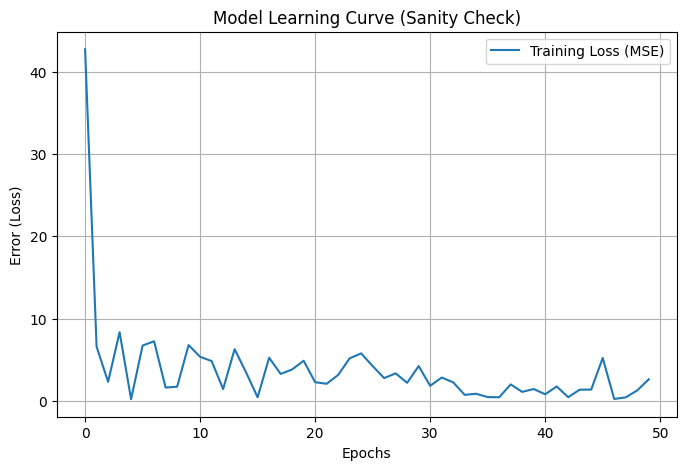

In [4]:
import matplotlib.pyplot as plt

# 1. Train the Model
print("Starting Training...")
# We save the training 'history' so we can plot the learning curve later
history = model.fit(
    X_train, y_train,
    epochs=50,          # Loop over the data 50 times
    batch_size=1,       # Update weights after every sample
    verbose=1           # Print a log line for every epoch
)

print("\nTraining Complete!")

# 2. Check the Final Score
final_loss = history.history['loss'][-1]
print(f"Final Mean Squared Error (Loss): {final_loss:.4f}")

# 3. Visualize the "Learning Curve"
# If the line goes DOWN, the brain is learning!
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.title('Model Learning Curve (Sanity Check)')
plt.xlabel('Epochs')
plt.ylabel('Error (Loss)')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
import deepchem as dc
import os
import numpy as np
from rdkit import Chem

print("Downloading 'Janitor-Cleaned' Biological Data...")

# 1. Download separate files for the Protein (Lock) and Ligand (Key)
# These are from the official DeepChem test assets
files = {
    'ligand': 'https://raw.githubusercontent.com/deepchem/deepchem/master/deepchem/utils/tests/assets/3pbl_ligand.sdf',
    'protein': 'https://raw.githubusercontent.com/deepchem/deepchem/master/deepchem/utils/tests/assets/3pbl_protein.pdb'
}

for name, url in files.items():
    os.system(f"wget -q {url} -O {name}_clean.dat") # Saving with generic extension to be safe

# 2. Load them into RDKit
# Note: Ligands are often in .sdf format (better for drugs), Proteins in .pdb
ligand = next(Chem.SDMolSupplier('ligand_clean.dat'))
protein = Chem.MolFromPDBFile('protein_clean.dat')

print(f"Loaded Ligand: {ligand.GetNumAtoms()} atoms")
print(f"Loaded Protein: {protein.GetNumAtoms()} atoms")

# 3. The Featurizer (Standard Settings)
featurizer = dc.feat.RdkitGridFeaturizer(
    voxel_width=1.0, 
    box_width=20.0,
    sanitize=True, 
    flatten=False
)

# 4. Featurize the PAIR
# We explicitly tell it: (Ligand, Protein)
print("Voxelizing interaction...")
try:
    # The input must be a list of tuples: [(ligand, protein)]
    features = featurizer.featurize([(ligand, protein)])
    
    if len(features) > 0 and features[0].shape == (20, 20, 20, 8):
        print(f"\n✔ SUCCESS! Real Biological Grid Created.")
        print(f"Shape: {features[0].shape}")
        
        # 5. Feed it to your Brain (Prediction)
        # We need to reshape it to (1, 20, 20, 20, 8) because the model expects a batch
        real_input = np.expand_dims(features[0], axis=0)
        prediction = model.predict(real_input)
        print(f"\nPredicted Binding Affinity (pKd): {prediction[0][0]:.2f}")
    else:
        print("Featurization failed (Shape mismatch).")
        
except Exception as e:
    print(f"Error: {e}")

OSError: File error: Invalid input file ligand_clean.dat

In [7]:
import os

# 1. Define the filename
# We use the .keras extension (the modern standard for TensorFlow)
model_filename = "3d_protein_cnn.keras"

# 2. Save the model
model.save(model_filename)

print(f"✔ Model successfully saved as: {model_filename}")

# 3. Verify it exists on your drive
if os.path.exists(model_filename):
    size_mb = os.path.getsize(model_filename) / (1024 * 1024)
    print(f"  File Size: {size_mb:.2f} MB")
    print("  You can now download this file or load it later!")
else:
    print("  Error: File was not created.")

✔ Model successfully saved as: 3d_protein_cnn.keras
  File Size: 5.82 MB
  You can now download this file or load it later!


In [ ]:
# --- FUTURE USE ONLY ---
from tensorflow.keras.models import load_model

# Load the brain back from the file
# You do NOT need to run 'build_3d_cnn' again!
loaded_model = load_model("3d_protein_cnn.keras")

print("Model loaded! Ready to predict.")
# loaded_model.predict(some_new_data)